#1. Khởi tạo và Thiết lập Môi trường

In [4]:
!pip install nltk 
!pip install seaborn
import pandas as pd
import numpy as np
import os, re, random, nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import vstack

# Kết nối Drive và tải tài nguyên
import nltk

for pkg in ["stopwords", "wordnet", "omw-1.4", "punkt"]:
    try:
        nltk.data.find(pkg)
    except LookupError:
        nltk.download(pkg)

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Đọc dữ liệu và ánh xạ nhãn
df = pd.read_csv(r"C:\Users\PC\CS221\NoteBook_ML\labeled_data.csv")
df["labels"] = df["class"].map({0: "Hate", 1: "Offensive", 2: "neither"})

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#2.EDA TRỰC QUAN

C:\Users\PC\AppData\Local\Temp\ipykernel_1604\108502223.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', palette='viridis')


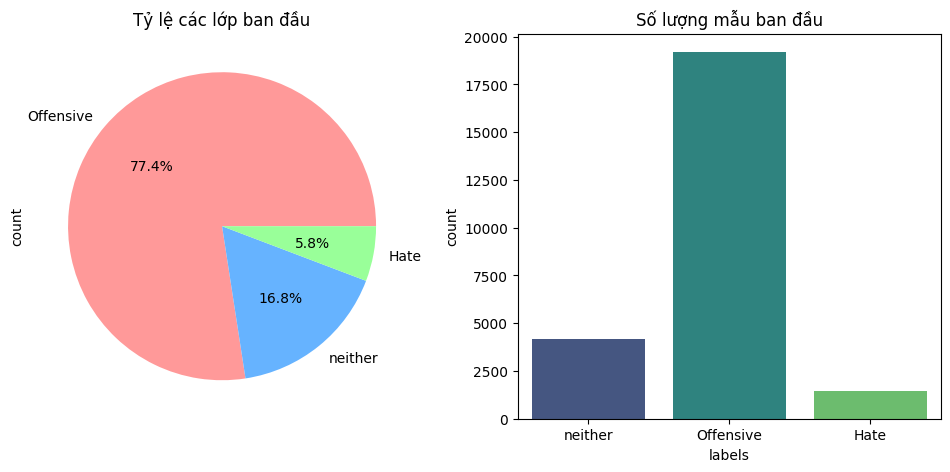

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['labels'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Tỷ lệ các lớp ban đầu")

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='labels', palette='viridis')
plt.title("Số lượng mẫu ban đầu")
plt.show()

#3. Chia Tập Dữ liệu

In [6]:
# Chia 80% Train và 20% còn lại (Tạm gọi là Temp)
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(
    df[['tweet']], df['labels'], test_size=0.2, random_state=42, stratify=df['labels']
)

# Chia 20% Temp thành 10% Val và 10% Test (tỷ lệ 1:1)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Kích thước: Train: {len(X_train_raw)} | Val: {len(X_val_raw)} | Test: {len(X_test_raw)}")

Kích thước: Train: 19826 | Val: 2478 | Test: 2479


#4. XỬ LÝ MẤT CÂN BẰNG & TĂNG CƯỜNG DỮ LIỆU

In [7]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace('_', ' ').replace('-', ' ').lower()
            if synonym != word.lower(): synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n: break
    return new_words

def augment_sentence(sentence):
    words = str(sentence).split()
    if len(words) < 3: return sentence
    n = max(1, int(len(words) * 0.15))
    return ' '.join(synonym_replacement(words, n))

# Thực hiện trên tập 80% Train
train_df_orig = pd.concat([X_train_raw, y_train_raw], axis=1)
hate_train = train_df_orig[train_df_orig['labels'] == 'Hate']
offensive_train = train_df_orig[train_df_orig['labels'] == 'Offensive']
neither_train = train_df_orig[train_df_orig['labels'] == 'neither']

hate_aug1 = hate_train.copy(); hate_aug1['tweet'] = hate_aug1['tweet'].apply(augment_sentence)
hate_aug2 = hate_train.copy(); hate_aug2['tweet'] = hate_aug2['tweet'].apply(augment_sentence)
offensive_down = offensive_train.sample(n=4000, random_state=42)

balanced_train_df = pd.concat([hate_train, hate_aug1, hate_aug2, offensive_down, neither_train], axis=0).reset_index(drop=True)

#5. EDA TRỰC QUAN

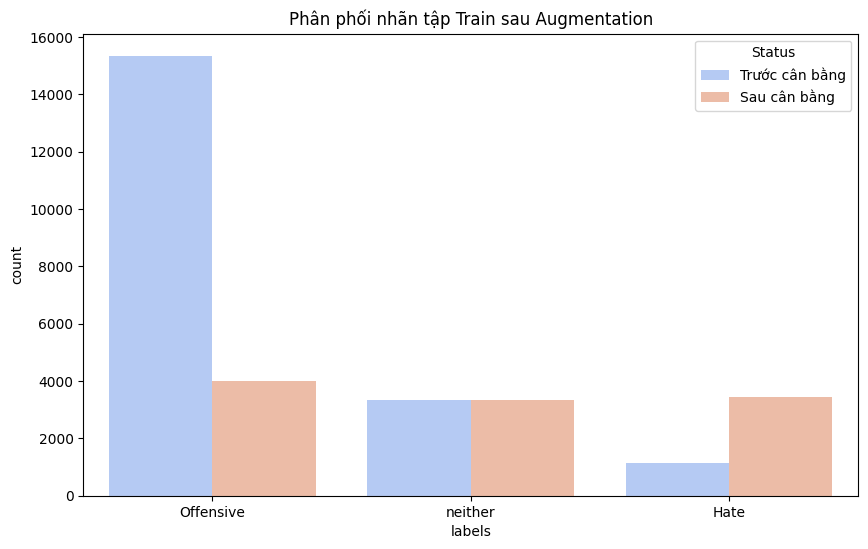

In [8]:
plt.figure(figsize=(10, 6))
b_counts = train_df_orig['labels'].value_counts().reset_index(); b_counts['Status'] = 'Trước cân bằng'
a_counts = balanced_train_df['labels'].value_counts().reset_index(); a_counts['Status'] = 'Sau cân bằng'
sns.barplot(data=pd.concat([b_counts, a_counts]), x='labels', y='count', hue='Status', palette='coolwarm')
plt.title("Phân phối nhãn tập Train sau Augmentation")
plt.show()

#6. TIỀN XỬ LÝ VÀ TRÍCH XUẤT ĐẶC TRƯNG

In [9]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

# Áp dụng tiền xử lý
balanced_train_df['clean_tweet'] = balanced_train_df['tweet'].apply(preprocess_text)
X_val_clean = X_val_raw['tweet'].apply(preprocess_text)
X_test_clean = X_test_raw['tweet'].apply(preprocess_text)

# Vector hóa (Fit trên tập Train)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = tfidf.fit_transform(balanced_train_df['clean_tweet'])
X_val_vec = tfidf.transform(X_val_clean)
X_test_vec = tfidf.transform(X_test_clean)

#7. Thiết lập Validation Split

In [10]:
# Gộp Train và Val để dùng PredefinedSplit
X_tuning = vstack([X_train_vec, X_val_vec])
y_tuning = pd.concat([balanced_train_df['labels'], y_val_raw], axis=0)

# -1 cho Train, 0 cho Validation
split_index = [-1] * X_train_vec.shape[0] + [0] * X_val_vec.shape[0]
pds = PredefinedSplit(test_fold=split_index)

#8. Tuning & Đánh giá LOGISTIC REGRESSION

--- Tuning Logistic Regression ---

BÁO CÁO LOGISTIC REGRESSION (Tập Test):
              precision    recall  f1-score   support

        Hate       0.36      0.52      0.42       143
   Offensive       0.96      0.88      0.92      1919
     neither       0.79      0.96      0.87       417

    accuracy                           0.88      2479
   macro avg       0.70      0.79      0.74      2479
weighted avg       0.90      0.88      0.88      2479



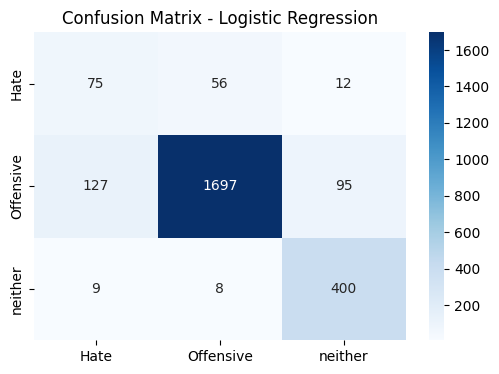

In [11]:
print("--- Tuning Logistic Regression ---")
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), {'max_iter': [500, 1000, 1500]}, cv=pds, scoring='f1_weighted', n_jobs=-1)
grid_lr.fit(X_tuning, y_tuning)

# Đánh giá trên tập Test sạch 10%
y_pred_lr = grid_lr.best_estimator_.predict(X_test_vec)
print("\nBÁO CÁO LOGISTIC REGRESSION (Tập Test):")
print(classification_report(y_test_raw, y_pred_lr))

# Ma trận nhầm lẫn
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_raw, y_pred_lr), annot=True, fmt='d', cmap='Blues',
            xticklabels=["Hate", "Offensive", "neither"], yticklabels=["Hate", "Offensive", "neither"])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [12]:
sample = "i hate you you stupid ugly cunt od a motherfucking whore"
sample = preprocess_text(sample)

In [13]:
sample

'hate stupid ugli cunt od motherfuck whore'

In [14]:
sample_vec = tfidf.transform([sample])

In [15]:
grid_lr.predict(sample_vec)

array(['Hate'], dtype=object)

#9. Tuning & Đánh giá SVM

--- Tuning SVM ---


c:\Users\PC\miniconda3\envs\hate-bert-ig\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



BÁO CÁO SVM (Tập Test):
              precision    recall  f1-score   support

        Hate       0.38      0.55      0.45       143
   Offensive       0.97      0.88      0.92      1919
     neither       0.76      0.96      0.85       417

    accuracy                           0.87      2479
   macro avg       0.70      0.80      0.74      2479
weighted avg       0.90      0.87      0.88      2479



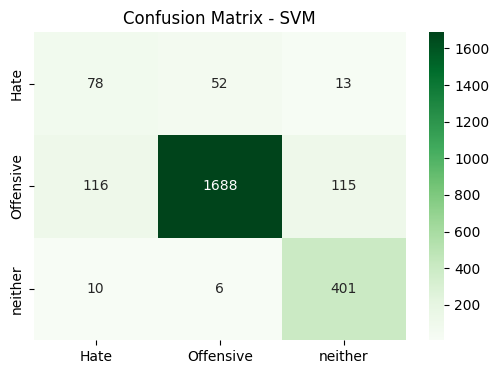

In [16]:
print("--- Tuning SVM ---")
grid_svm = GridSearchCV(LinearSVC(random_state=42), {'C': [0.1, 1.0, 10.0], 'max_iter': [1000, 2000]}, cv=pds, scoring='f1_weighted', n_jobs=-1)
grid_svm.fit(X_tuning, y_tuning)

y_pred_svm = grid_svm.best_estimator_.predict(X_test_vec)
print("\nBÁO CÁO SVM (Tập Test):")
print(classification_report(y_test_raw, y_pred_svm))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_raw, y_pred_svm), annot=True, fmt='d', cmap='Greens',
            xticklabels=["Hate", "Offensive", "neither"], yticklabels=["Hate", "Offensive", "neither"])
plt.title("Confusion Matrix - SVM")
plt.show()

#10. Tuning & Đánh giá RANDOM FOREST

--- Tuning Random Forest ---

BÁO CÁO RANDOM FOREST (Tập Test):
              precision    recall  f1-score   support

        Hate       0.37      0.52      0.43       143
   Offensive       0.96      0.89      0.93      1919
     neither       0.78      0.94      0.85       417

    accuracy                           0.88      2479
   macro avg       0.70      0.79      0.74      2479
weighted avg       0.90      0.88      0.89      2479



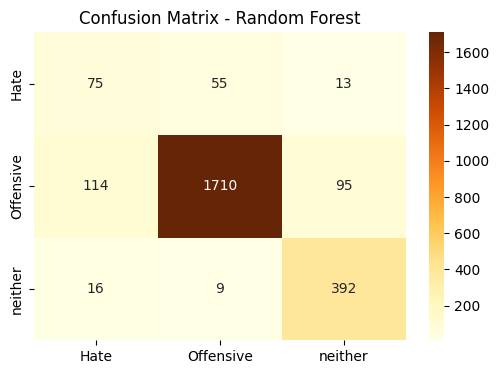

In [17]:
print("--- Tuning Random Forest ---")
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), {'n_estimators': [50, 100, 200]}, cv=pds, scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_tuning, y_tuning)

y_pred_rf = grid_rf.best_estimator_.predict(X_test_vec)
print("\nBÁO CÁO RANDOM FOREST (Tập Test):")
print(classification_report(y_test_raw, y_pred_rf))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_raw, y_pred_rf), annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=["Hate", "Offensive", "neither"], yticklabels=["Hate", "Offensive", "neither"])
plt.title("Confusion Matrix - Random Forest")
plt.show()

BẢNG SO SÁNH HIỆU NĂNG TỔNG THỂ:


,Accuracy,Precision,Recall,F1-Score
Model,,,,
Logistic Regression,0.876,0.899,0.876,0.884
SVM,0.874,0.898,0.874,0.882
Random Forest,0.878,0.899,0.878,0.886


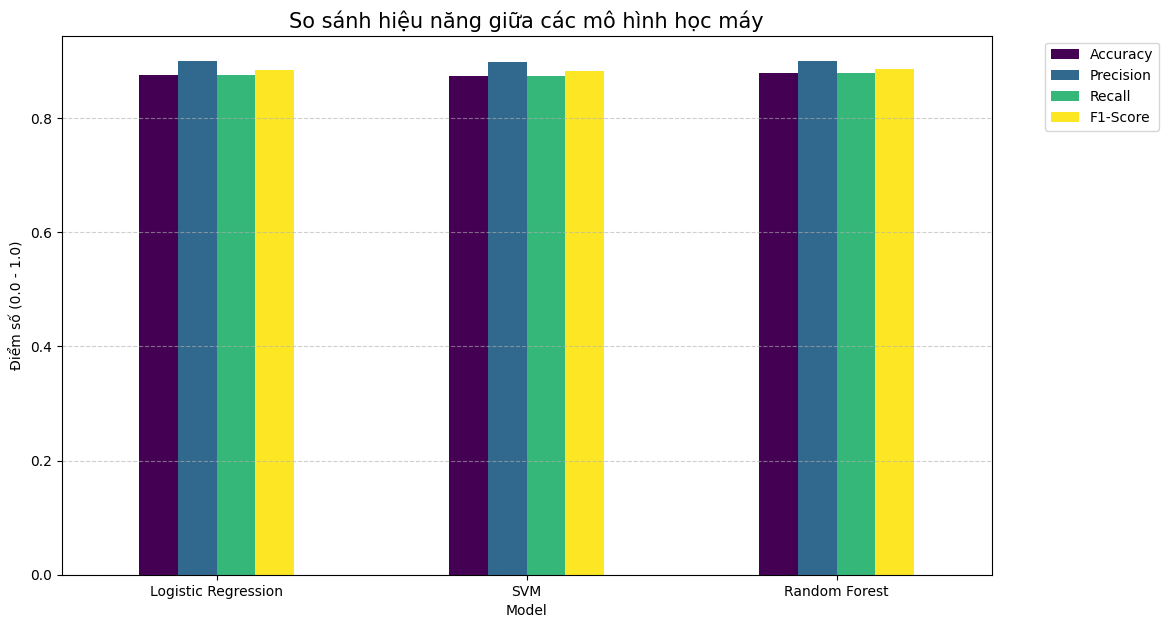

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def get_metrics(y_true, y_pred, model_name):
    # Tính toán các chỉ số weighted average
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return {
        "Model": model_name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3)
    }

# 1. Thu thập dữ liệu từ các mô hình đã huấn luyện
comparison_list = []
comparison_list.append(get_metrics(y_test_raw, y_pred_lr, "Logistic Regression"))     # y_pred từ Mục 7
comparison_list.append(get_metrics(y_test_raw, y_pred_svm, "SVM"))               # y_pred_svm từ Mục 8
comparison_list.append(get_metrics(y_test_raw, y_pred_rf, "Random Forest"))      # y_pred_rf từ Mục 10

# 2. Tạo DataFrame so sánh
performance_df = pd.DataFrame(comparison_list).set_index("Model")

print("BẢNG SO SÁNH HIỆU NĂNG TỔNG THỂ:")
display(performance_df)

# 3. Trực quan hóa bằng biểu đồ cột
performance_df.plot(kind='bar', figsize=(12, 7), colormap='viridis')
plt.title("So sánh hiệu năng giữa các mô hình học máy", fontsize=15)
plt.ylabel("Điểm số (0.0 - 1.0)")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [19]:
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted

check_is_fitted(tfidf, attributes=["vocabulary_", "idf_"])
print("TFIDF fitted OK (vocab + idf)")

save_dir = r"C:\Users\PC\CS221\outputs_ML\\"
os.makedirs(save_dir, exist_ok=True)

pipe_lr  = Pipeline([("tfidf", tfidf), ("clf", grid_lr.best_estimator_)])
pipe_svm = Pipeline([("tfidf", tfidf), ("clf", grid_svm.best_estimator_)])
pipe_rf  = Pipeline([("tfidf", tfidf), ("clf", grid_rf.best_estimator_)])

joblib.dump(pipe_lr,  os.path.join(save_dir, "pipe_lr.pkl"))
joblib.dump(pipe_svm, os.path.join(save_dir, "pipe_svm.pkl"))
joblib.dump(pipe_rf,  os.path.join(save_dir, "pipe_rf.pkl"))

print("Saved: pipe_lr.pkl, pipe_svm.pkl, pipe_rf.pkl")


TFIDF fitted OK (vocab + idf)
Saved: pipe_lr.pkl, pipe_svm.pkl, pipe_rf.pkl
